In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### EDA

In [43]:
df_train = pd.read_csv("data/train.csv",index_col='id')
df_test = pd.read_csv("data/test.csv",index_col='id')


In [44]:
df_train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


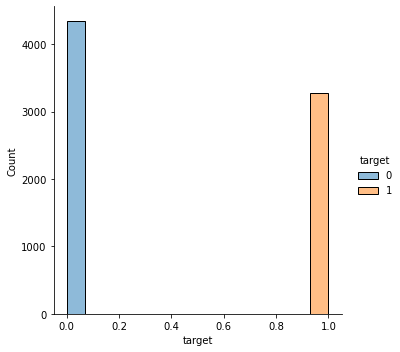

In [23]:
sns.displot(data=df_train, x='target', hue='target')

<AxesSubplot:>

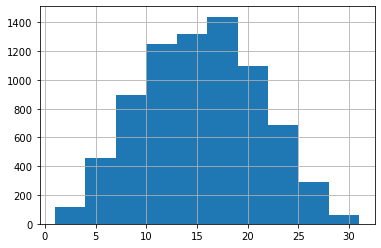

In [45]:
df_train['length'] =  df_train['text'].apply(lambda x: len(x.split())).values
df_train['length'].hist()

### Data Cleaning

In [46]:
import string, re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/tkindvall/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tkindvall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
def clean_text(t):
    t  = "".join([char for char in t if char not in string.punctuation])
    t = re.sub('[0-9]+', '', t)
    
    t = t.lower() # lowercase
    
    t = t.replace(r"\#","",True) # replaces hashtags
    t = t.replace(r"http\S+","URL", True )  # remove URL addresses
    t = t.replace(r"@","",  True )
    t = t.replace("\s{2,}", " ", True ) # remove multiple contiguous spaces
    return t


In [61]:
df_train['text'] = df_train['text'].apply(lambda t: clean_text(t))
df_test['text'] = df_test['text'].apply(lambda t: clean_text(t))
 
df_train_clean.head()

,keyword,location,text,target,length
id,,,,,
1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,13
4,NaN,NaN,forest fire near la ronge sask canada,1,7
5,NaN,NaN,all residents asked to shelter in place are be...,1,22
6,NaN,NaN,people receive wildfires evacuation orders in...,1,8
7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,16


### Model Architecture
#### GRU

In [86]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text 
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.layers import TextVectorization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [66]:
xtrain, xtest, ytrain, ytest = train_test_split(
    df_train['text'].values,
    df_train['target'].values,
    shuffle=True,
    test_size=0.2)

In [135]:
max_text_len = max(df_train['text'].apply(lambda x: len(x.split())).values) # we know this from the EDA
max_words = 50000
tokenizer = text.Tokenizer(num_words = max_words)

tokenizer.fit_on_texts(xtrain) #fit tokens on training data

xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

In [136]:
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_text_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_text_len)
word_index = tokenizer.word_index
 
print('text example:', xtrain[0])
print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])

text example: mourning notices for stabbing arson victims stir û÷politics of griefûª in israel httptcoqldgjm
sequence of indices(before padding): [2352, 1744, 9, 2353, 576, 924, 2354, 2355, 5, 2356, 3, 925, 5715]
sequence of indices(after padding): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 2352 1744    9 2353  576  924 2354 2355    5 2356
    3  925 5715]


In [124]:
#https://nlp.stanford.edu/projects/glove/
#!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip g*zip

348795.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [137]:
%%time
embedding_vectors = {}
with open('glove.6B.300d.txt','r',encoding='utf-8') as file: #glove.42B.300d.txt
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")

Size of vocabulary in GloVe: 400000
CPU times: user 1min 26s, sys: 25.5 s, total: 1min 52s
Wall time: 1min 51s


In [138]:
emb_dim = 300
vocab_len = max_words if max_words is not None else len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')

Some out of valubulary words: ['\x89û', '\x89ûò', 'prebreak', 'nowplaying', 're\x89û']
7969 out of 50000 words were OOV.


In [139]:
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
                              
                              
callbacks_list = [reducel, earlystopper]

In [140]:
def plot_model_acc(model_history):
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.figure()

In [141]:
model_lstm = Sequential(name='model_lstm')
model_lstm.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
#model_lstm.add(Embedding(vocab_len, emb_dim, trainable = True))
model_lstm.add(LSTM(64, activation='tanh', return_sequences=False))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(tf.keras.layers.BatchNormalization())
model_lstm.add(Dropout(0.2)) # Adding Dropout layer with rate of 0.2
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
model_lstm.summary()

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 300)         15000000  
                                                                 
 lstm_5 (LSTM)               (None, 64)                93440     
                                                                 
 dense_23 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               33024     
                                                        

In [142]:
%%time
batch_size = 32
epochs  = 20
history_lstm = model_lstm.fit(xtrain_pad,
    np.asarray(ytrain),
    validation_data=(xtest_pad, np.asarray(ytest)),
    batch_size = batch_size,
    epochs = epochs,
    callbacks = callbacks_list)

Epoch 1/20
191/191 [==============================] - 15s 41ms/step - loss: 0.5001 - accuracy: 0.7700 - recall_4: 0.6563 - auc_4: 0.8246 - val_loss: 0.5393 - val_accuracy: 0.7814 - val_recall_4: 0.7022 - val_auc_4: 0.8524 - lr: 0.0010
Epoch 2/20
191/191 [==============================] - 6s 31ms/step - loss: 0.4155 - accuracy: 0.8172 - recall_4: 0.7136 - auc_4: 0.8819 - val_loss: 0.4920 - val_accuracy: 0.7741 - val_recall_4: 0.5078 - val_auc_4: 0.8520 - lr: 0.0010
Epoch 3/20
191/191 [==============================] - 6s 29ms/step - loss: 0.3770 - accuracy: 0.8365 - recall_4: 0.7391 - auc_4: 0.9023 - val_loss: 0.4778 - val_accuracy: 0.7951 - val_recall_4: 0.6364 - val_auc_4: 0.8533 - lr: 0.0010
Epoch 4/20
191/191 [==============================] - ETA: 0s - loss: 0.3470 - accuracy: 0.8530 - recall_4: 0.7710 - auc_4: 0.9182
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
191/191 [==============================] - 6s 31ms/step - loss: 0.3470 - accuracy: 0.8530

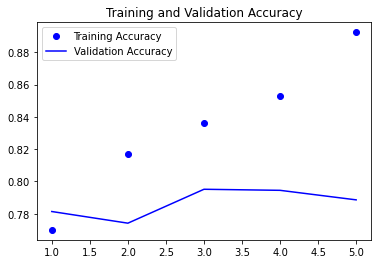

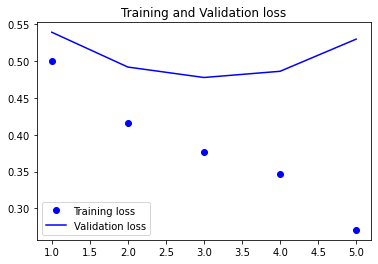

<Figure size 432x288 with 0 Axes>

In [143]:
plot_model_acc(history_lstm)

In [144]:
emb_dim = embedding_matrix.shape[1]
model_gru = Sequential(name='model_gru')
model_gru.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
model_gru.add(GRU(128, return_sequences=False))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation = 'sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "model_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 300)         15000000  
                                                                 
 gru_3 (GRU)                 (None, 128)               165120    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 129       
                                                                 
Total params: 15165249 (57.85 MB)
Trainable params: 165249 (645.50 KB)
Non-trainable params: 15000000 (57.22 MB)
_________________________________________________________________


Epoch 1/20
191/191 [==============================] - 14s 54ms/step - loss: 0.5035 - accuracy: 0.7530 - val_loss: 0.4549 - val_accuracy: 0.7984 - lr: 0.0010
Epoch 2/20
191/191 [==============================] - ETA: 0s - loss: 0.4106 - accuracy: 0.8246
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
191/191 [==============================] - 10s 54ms/step - loss: 0.4106 - accuracy: 0.8246 - val_loss: 0.4691 - val_accuracy: 0.8024 - lr: 0.0010
Epoch 3/20
191/191 [==============================] - 8s 41ms/step - loss: 0.3620 - accuracy: 0.8491 - val_loss: 0.4472 - val_accuracy: 0.8043 - lr: 1.0000e-04
Epoch 4/20
191/191 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.8484
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
191/191 [==============================] - 8s 39ms/step - loss: 0.3589 - accuracy: 0.8484 - val_loss: 0.4498 - val_accuracy: 0.8017 - lr: 1.0000e-04
Epoch 5/20
191/191 [======================

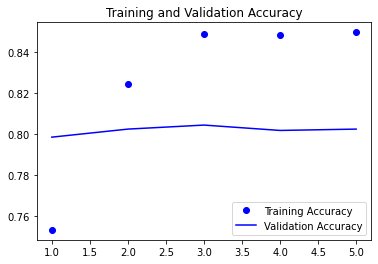

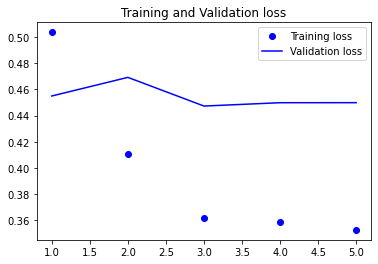

<Figure size 432x288 with 0 Axes>

In [145]:
batch_size = 32
epochs  = 20
history_gru = model_gru.fit(xtrain_pad,
                         np.asarray(ytrain),
                         validation_data=(xtest_pad, np.asarray(ytest)),
                         batch_size = batch_size,
                         epochs = epochs,
                         callbacks = callbacks_list)

plot_model_acc(history_gru)

In [156]:
X_test= df_test['text'].values
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_text_len)
predictions_prob = model_gru.predict(X_test_pad)
predictions = tf.round(predictions_prob)
#print(predictions)

print(df_test.columns)
df_out = pd.DataFrame()
df_out.index = df_test.index
df_out['target'] = predictions
df_out.to_csv('submission.csv')


102/102 [==============================] - 2s 15ms/step
Index(['keyword', 'location', 'text'], dtype='object')
